Separamos el dataset en 3 conjuntos, el de entrenamiento (70%), uno de validacion (20%), y otro de test (10%)

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Ruta de la carpeta principal que contiene subcarpetas por raza
data_folder = './Images/'

# Ruta de la carpeta de destino para los conjuntos de datos
output_folder = './Conjuntos/'

# Porcentaje de datos para entrenamiento, validación y prueba
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Crear carpetas de salida si no existen
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)

# Iterar sobre las carpetas de raza
for breed_folder in os.listdir(data_folder):
    breed_path = os.path.join(data_folder, breed_folder)

    # Lista de imágenes en la carpeta de raza
    images = [img for img in os.listdir(breed_path) if img.endswith('.jpg')]

    # Dividir la lista de imágenes en conjuntos de entrenamiento, validación y prueba
    train_images, test_images = train_test_split(images, test_size=val_size + test_size, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_size / (val_size + test_size), random_state=42)

    # Mover imágenes a las carpetas correspondientes
    for img in train_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'train', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for img in val_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'val', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for img in test_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'test', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)



In [8]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir directorios de datos
train_data_dir = './Conjuntos/train/'  # Directorio de entrenamiento
validation_data_dir = './Conjuntos/val'  # Directorio de validación
test_data_dir = './Conjuntos/test/'  # Directorio de prueba
image_size = (150, 150)  # Tamaño de la imagen
batch_size = 32  # Tamaño del lote

# Carga de Dataset de entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Carga de Dataset de validación
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Carga de Dataset de test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Buffer mejora del rendimiento
train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)


Found 14338 files belonging to 120 classes.
Found 4113 files belonging to 120 classes.
Found 2129 files belonging to 120 classes.


Data Augmentation

In [9]:
# Configuración del generador de datos para el entrenamiento con aumentación
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalizar valores de píxeles al rango [0, 1]
    rotation_range=15,       # Rango de rotación aleatoria en grados
    zoom_range=0.1           # Rango de zoom aleatorio
)

# Configuración del generador de datos para la validación
validation_datagen = ImageDataGenerator(
    rescale=1./255  # Normalizar valores de píxeles al rango [0, 1]
)

# Crear generadores de flujo de datos con aumentación
train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds_augmentation = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14338 images belonging to 120 classes.
Found 4113 images belonging to 120 classes.


Iniciar el modelo

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    

model = Sequential()
#Escalado de imagenes RGB
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

#Primera capa convolutiva
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) # Activacion de señal
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # Fully Connected
model.add(Dropout(0.5))

model.add(Dense(120, activation='softmax'))

model.summary()

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               22429824  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

Entrenamiento del modelo

In [11]:

from tensorflow.keras.callbacks import EarlyStopping

epochs = 150

# Detiene el entrenamiento tempranamente
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True) 

# Entrena el modelo.
history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)

Epoch 1/150
449/449 [==============================] - 156s 346ms/step - loss: 4.9246 - accuracy: 0.0112 - val_loss: 4.7843 - val_accuracy: 0.0122
Epoch 2/150
449/449 [==============================] - 146s 326ms/step - loss: 4.7851 - accuracy: 0.0120 - val_loss: 4.7822 - val_accuracy: 0.0122
Epoch 3/150
449/449 [==============================] - 147s 326ms/step - loss: 4.7823 - accuracy: 0.0123 - val_loss: 4.7809 - val_accuracy: 0.0122
Epoch 4/150
449/449 [==============================] - 148s 328ms/step - loss: 4.7813 - accuracy: 0.0123 - val_loss: 4.7801 - val_accuracy: 0.0122
Epoch 5/150
449/449 [==============================] - 148s 329ms/step - loss: 4.7808 - accuracy: 0.0123 - val_loss: 4.7796 - val_accuracy: 0.0122
Epoch 6/150
449/449 [==============================] - 145s 323ms/step - loss: 4.7852 - accuracy: 0.0124 - val_loss: 4.7792 - val_accuracy: 0.0122
Epoch 7/150
449/449 [==============================] - 147s 326ms/step - loss: 4.7800 - accuracy: 0.0123 - val_loss: 4

Guardar el modelo

In [12]:
model.save('./modelos/perros.h1')

INFO:tensorflow:Assets written to: ./modelos/perros.h1\assets


INFO:tensorflow:Assets written to: ./modelos/perros.h1\assets


Procesamiento de los datos

1/1 [==============================] - 0s 86ms/step


c:\Users\sheil\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sheil\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sheil\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        30
           1     0.0000    0.0000    0.0000        37
           2     0.0122    1.0000    0.0240        50
           3     0.0000    0.0000    0.0000        30
           4     0.0000    0.0000    0.0000        43
           5     0.0000    0.0000    0.0000        38
           6     0.0000    0.0000    0.0000        39
           7     0.0000    0.0000    0.0000        34
           8     0.0000    0.0000    0.0000        34
           9     0.0000    0.0000    0.0000        48
          10     0.0000    0.0000    0.0000        35
          11     0.0000    0.0000    0.0000        39
          12     0.0000    0.0000    0.0000        38
          13     0.0000    0.0000    0.0000        34
          14     0.0000    0.0000    0.0000        32
          15     0.0000    0.0000    0.0000        30
          16     0.0000    0.0000    0.0000        32
          17     0.0000    

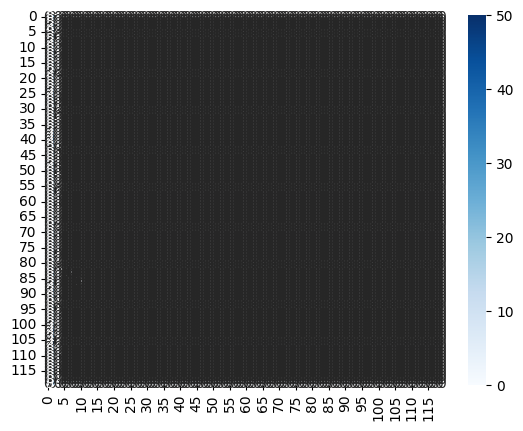

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
model = tensorflow.keras.models.load_model('./modelos/perros.h1')
results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))